In [49]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D, get_t
from torch_helper import to_torch, to_torch_3D, torch_func, inner_product, angle

from scipy.integrate import cumulative_trapezoid
from scipy.special import airy
from scipy.signal import find_peaks, argrelextrema
from skimage.segmentation import flood
from scipy.optimize import brentq

from warnings import warn

In [50]:
from diff_func_fitters import fit_polynomial, fit_rational_func

In [51]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

In [52]:
from skimage.segmentation import flood

def np_inner_product(a, b):
    return np.einsum('...i,...i->...', a, b)

def sgn_mask_from_seed(a, seed):
    '''returns boolean array mask for the "sign branch" connected to the seed index.
    A "sign branch" is here defined as a connected region where the sign of the array `a` is constant.
    '''
    return flood(np.signbit(a), seed)

def get_masks_of_const_sgn(a, ND=3):
    '''returns list of boolean arrays with masks which
    subdivide the values of the array, `a`,
    into regions where the sign is constant.'''
    seed = (0) * ND
    regions_remaining = True
    masks = []
    while regions_remaining:
        masks.append(sgn_mask_from_seed(a, seed))
        remaining_cells = np.argwhere(np.any(masks, axis=0) == False)
        if len(remaining_cells) > 0:
            seed = tuple(remaining_cells[0])
        else:
            regions_remaining = False
    return masks

### Dispersion Function

In [53]:
# Define Warm Plasma Dispersion Relation
import torch
from scipy.constants import e, m_e, epsilon_0, c

# ICs
f0 = 34.8e9
omega0 = 2*np.pi*f0
x0 = 0

# Constants
n0 = 2.07e19
T0 = 38.5*e
L_ne = 2.8434e-2
L_Te = 0.7295*L_ne
B0 = 0.511

sc_x = 1
sc_k = 1
sc_omega = 1

@torch_func
def B(x: ('scalar')):
    return B0 * torch.ones_like(x)

@torch_func
def omega_c(x: ('scalar')):
    return e*B(x)/m_e

@torch_func
def T_e(x: ('scalar')):
    return T0*(1 - x/L_Te)

@torch_func
def n_e(x: ('scalar')):
    return n0*(1 - x/L_ne)

@torch_func
def omega_p_squared(x: ('scalar')):
    return n_e(x) * e**2 / (epsilon_0 * m_e)

@torch_func
def v_Te_squared(x: ('scalar')):
    return 2*T_e(x)/m_e

@torch_func
def Stix_S(x: ('scalar'), omega: ('scalar')):
    return 1 - (omega_p_squared(x)/(omega**2 - (omega_c(x)**2 )))

@torch_func
def Stix_D(x: ('scalar'), omega: ('scalar')):
    return (omega_c(x)/omega) * (omega_p_squared(x)/(omega**2 - (omega_c(x)**2)))

@torch_func
def lamb(x: ('scalar'), k: ('scalar')):
    return v_Te_squared(x)/(2 * (omega_c(x)**2)) * (torch.abs(k)**2)

@torch_func
def Omega(x: ('scalar'), omega: ('scalar')):
    return omega/omega_c(x)

@torch_func
def K1_int(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    _psi = torch.linspace(0, torch.pi, 100)
    return torch.exp(-lamb(x, k)) * torch.trapezoid(torch.sin(_psi*Omega(x, omega))*torch.sin(_psi)*torch.exp(-lamb(x, k)*torch.cos(_psi)), _psi)

@torch_func
def K1(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return (1
     + (omega_p_squared(x)/(omega_c(x)**2)) / (torch.sin(torch.pi * Omega(x, omega)))
        * (K1_int(x, k, omega))
    )

@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    _x = sc_x * x
    _k = sc_k * k
    _omega = sc_omega * omega
    return (c/_omega)**2 * (K1(_x, _k, _omega) * (torch.abs(_k)**2) - (_omega/c)**2 * (Stix_S(_x, _omega)**2 - Stix_D(_x, _omega)**2))

def get_k0(x0, omega0, kmin, kmax):
    return brentq(lambda k: D(x0, k, omega0), kmin, kmax)

#### Test Dispersion on a $(x, k, \omega)$ point

In [54]:
k0 = 10e3 / sc_k
f0 = 34.8e9 / sc_omega
omega0 = 2*np.pi*f0
x0 = 1 / sc_x

print(
    'B', B(x0),
    '\n omega_c', omega_c(x0),
    '\n n_e', n_e(x0),
    '\n omega_p_squared', omega_p_squared(x0),
    '\n Stix_S', Stix_S(x0, omega0),
    '\n Stix_D', Stix_D(x0, omega0),
    '\n lambd', lamb(x0, k0),
    '\n v_Te_squared', v_Te_squared(x0),
    '\n K1_int', K1_int(x0, k0, omega0),
    '\n K1', K1(x0, k0, omega0),
    '\n D', D(x0, k0, omega0),
)

B tensor(0.5110) 
 omega_c tensor(8.9876e+10) 
 n_e tensor(-7.0730e+20) 
 omega_p_squared tensor(-2.2510e+24) 
 Stix_S tensor(57.6540) 
 Stix_D tensor(-23.2870) 
 lambd tensor(-3.9576) 
 v_Te_squared tensor(-6.3936e+14) 
 K1_int tensor(479.5933) 
 K1 tensor(-136676.3125) 
 D tensor(-25695878.)


#### Plot Dispersion in $(k, f)$ space

In [55]:
f0 = 34.8e9 / sc_omega
omega0 = 2*np.pi*f0
x0 = 0 / sc_x

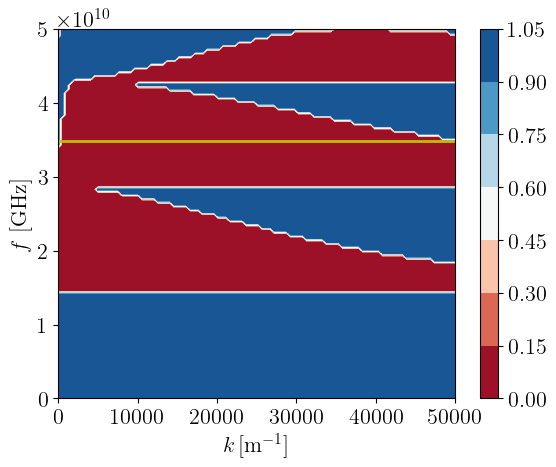

In [56]:
ki = np.linspace(0, 50000, 100) / sc_k
omegai = 2*np.pi*np.linspace(1e-6, 50e9, 100) / sc_omega
K, O = np.meshgrid(ki, omegai, indexing='ij')
D_vec = np.vectorize(D)

plt.contourf(K * sc_k, O/(2*np.pi) * sc_omega, D_vec(np.zeros_like(K), K, O) > 0, cmap='RdBu')
plt.plot(plt.gca().get_xlim(), [f0 * sc_omega, f0 * sc_omega], 'y-', linewidth=2)
plt.ylabel(r'$f$ [GHz]')
plt.xlabel(r'$k \, [\mathrm{m^{-1}}]$')
plt.colorbar()
plt.show()

#### Find initial $k_0$

In [57]:
k0 = get_k0(x0, omega0, 0, 1000 / sc_k)

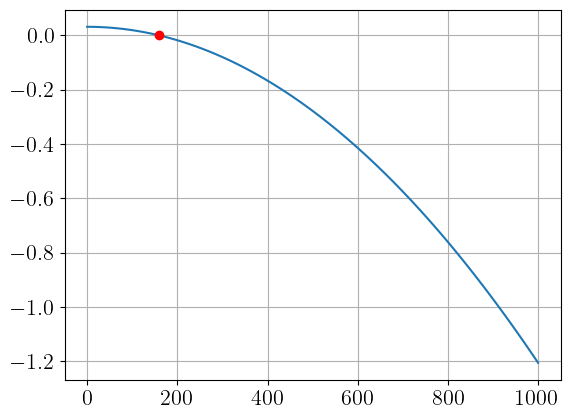

In [58]:
k_low = np.linspace(0, 1000 / sc_k, 100)
plt.plot(k_low * sc_k, D(x0, k_low, omega0))
plt.plot(k0 * sc_k, 0, 'ro')
plt.grid()
plt.show()

### Ray Tracing

In [59]:
sc_omega

1

In [60]:
nt = 45000
xs = np.zeros(nt)
ks = np.zeros(nt)

# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt

sol = trace_ray_1D(x0 = x0, k0=k0, omega0=omega0, tmin=0, tmax=40e-9*sc_omega, D=D, x_min=x0, tsteps=nt, solve_ivp_args={'method': 'LSODA'}, true_time=True, rtol=1e-9)
sol_nt = len(sol.t)
xs[:sol_nt] = sol.y[0]
ks[:sol_nt] = sol.y[1]
min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
xs = xs[:min_nt]
ks = ks[:min_nt]
print(nt)

40636


In [61]:
traced_D = D_vec(xs, ks, omega0*np.ones_like(xs))

In [62]:
plt.plot(t / sc_omega, traced_D, label='$D(x(t), k(t), \omega)$')
plt.ylim(-0.01, 0.01)
plt.xlabel(r'$t$ [ns]')
plt.legend()
plt.grid()

In [63]:
# fig = plt.figure(figsize=(5,4))
# plt.plot(xs[t < 24]*1e3, ks[np.round(traced_D, 1) == 0]*1e-3, 'k-')
# plt.plot(xs[t < 24]*1e3, ks[np.round(traced_D, 1) != 0]*1e-3, 'k--')
# plt.xlabel(r'$x$ [mm]')
# plt.ylabel(r'$k_x \, \mathrm{[mm^{-1}]}$')
# plt.grid()
# plt.tight_layout()
# # plt.savefig('./plots/1D_warm_dispersion_manifold.png')
# # plt.savefig('./plots/1D_warm_dispersion_manifold.pdf')
# plt.show()

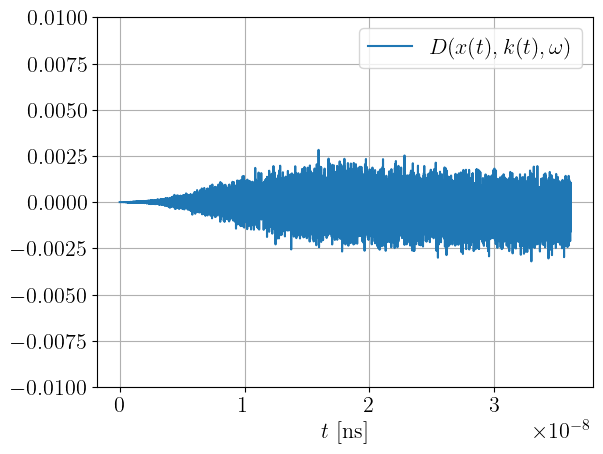

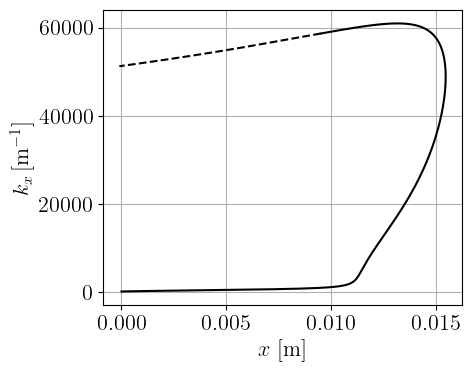

In [64]:
fig = plt.figure(figsize=(5,4))
plt.plot(xs[t / sc_omega < 25e-9] * sc_x, ks[t / sc_omega < 25e-9] * sc_k, 'k-')
plt.plot(xs[t / sc_omega >= 25e-9] * sc_x, ks[t / sc_omega >= 25e-9] * sc_k, 'k--')
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$k_x \, \mathrm{[m^{-1}]}$')
plt.grid()
plt.tight_layout()
# plt.savefig('./plots/1D_warm_dispersion_manifold.png')
# plt.savefig('./plots/1D_warm_dispersion_manifold.pdf')
plt.show()

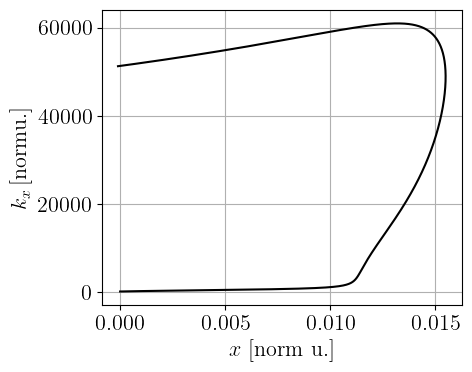

In [65]:
fig = plt.figure(figsize=(5,4))
plt.plot(xs[np.round(traced_D, 1) == 0], ks[np.round(traced_D, 1) == 0], 'k-')
plt.plot(xs[np.round(traced_D, 1) != 0], ks[np.round(traced_D, 1) != 0], 'k--')
plt.xlabel(r'$x$ [norm u.]')
plt.ylabel(r'$k_x \, \mathrm{[norm u.]}$')
plt.grid()
plt.tight_layout()
# plt.savefig('./plots/1D_warm_dispersion_manifold.png')
# plt.savefig('./plots/1D_warm_dispersion_manifold.pdf')
plt.show()

### Symplectic Trfm

In [66]:
def gram_schmidt_orthogonalize(Q):
    N = Q.shape[-1]
    P = np.zeros(Q.shape)

    def norm(A, i):
        norms = np.sqrt(np_inner_product(A[..., i], A[..., i]))
        return np.stack([norms]*A.shape[-1], axis=-1)

    P[..., 0] = Q[..., 0]/norm(Q, 0)
    for k in range(1, N):
        P[..., k] = (Q[..., k]
                        - sum([(
            np.stack([np_inner_product(Q[..., k], P[..., j])]*N, axis=-1)
            ) * P[..., j] for j in range(k)]))
        P[..., k] = P[..., k]/norm(P, k)
    return P

ND = 1
zs = np.stack((xs, ks), axis=-1)
gradt_z = fd.grad(zs, t)
norms = np.sqrt(np_inner_product(gradt_z, gradt_z))
T1 = gradt_z/np.stack([norms]*zs.shape[-1], axis=-1) # normalised grad_t z(t, y0, z0)

# For each tau, create an identity matrix
eye = np.zeros(np.prod(zs.shape)*zs.shape[-1]).reshape((*zs.shape, zs.shape[-1]))
eye[..., :, :] = np.eye(zs.shape[-1])

# For each tau, create orthonormal basis starting from
# single tangent vector using Gram Schmidt orthogonalization
ONB = np.copy(eye)
ONB[..., 0] = T1
ONB = gram_schmidt_orthogonalize(ONB)

# Tangent space is first 3 vectors of basis:
# Note: Basis vectors in T are shaped as columns!
T = ONB[..., :ND]

# Create Symplectic Matrix (J)
symplJ = np.copy(ONB)
symplJ[..., :, :] =  np.block([
    [  np.zeros((ND, ND)),  np.eye((ND))        ],
    [  -np.eye(ND),         np.zeros((ND, ND))  ]])

def np_transpose(A):
    '''return transpose of only the last two dimensions.'''
    return np.moveaxis(A, -1, -2)

# Create symplectic/canonical transformation matrix
N = -np.matmul(symplJ, T)
R = np.concatenate((T, N), axis=-1)
S = np_transpose(R)
gradt_S = fd.grad(S, t)

### MGO

In [68]:
def get_branches(J):
    branch_masks = get_masks_of_const_sgn(J)
    J_desc = np.argsort(np.abs(J))[::-1]
    seeds = []
    branch_ranges = []
    for branch in branch_masks:
        branch_min, branch_max = np.min(np.argwhere(branch)), np.max(np.argwhere(branch))
        seed = J_desc[(branch_min <= J_desc) & (J_desc <= branch_max)][0]
        range_back, range_forward = range(seed, max(branch_min - 1, 0), -1), range(seed, min(branch_max + 1, nt - 1), +1)
        if len(range_back) > 0:
            branch_ranges.append(range_back)
            seeds.append(seed)
        if len(range_forward) > 0:
            branch_ranges.append(range_forward)
            seeds.append(seed)
    return branch_masks, seeds, branch_ranges

J = fd.grad(xs, t)
branch_masks, seeds, branch_ranges = get_branches(J)
print('seeds: ', seeds, 'branch_ranges: ', branch_ranges)


seeds:  [73, 73, 40635] branch_ranges:  [range(73, 0, -1), range(73, 11281), range(40635, 11280, -1)]


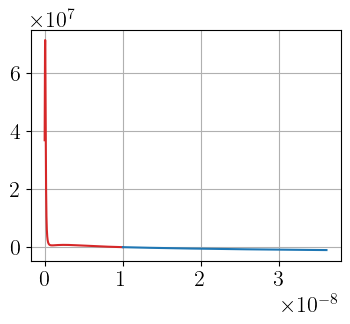

In [69]:
# # WARNING!
# # MANUAL OVERWRITE SEEDS AND BRANCH RANGES
# seeds = [0, len(t) - 1]
# branch_ranges = [range(0, len(t) - sum(branch_masks[1])), range(len(t) - 1, len(t) - sum(branch_masks[1]) -1, -1)]
# print([len(r) for r in branch_ranges], [sum(mask) for mask in branch_masks])

plt.figure(figsize=(4,3))
plt.plot(t[J>0], J[J>0], 'tab:red')
plt.plot(t[J<0], J[J<0], 'tab:blue')
plt.grid()
plt.show()

In [70]:
i_caust = np.argmin(np.abs(J))
t_save = t[i_caust] + np.array([-10, -2, -1, -0.3, -0.15, -0.1, -0.05, -0.01, 0, 0.01, 0.1, 0.15, 0.3, 1, 2, 10])*1e-9
i_save = [0] + [np.argmin(np.abs(t - t0)) for t0 in t_save] + [nt-1]

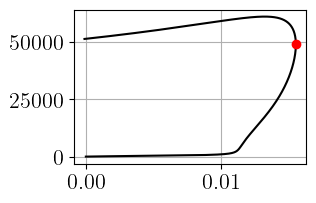

In [71]:
plt.figure(figsize=(3,2))
plt.plot(xs, ks, 'k-')
plt.plot(xs[i_caust], ks[i_caust], 'ro')
plt.grid()
plt.show()

In [72]:
# Times at which to save results
results = []

def init_at_seed(seed):
    # Initialization at seed time
    nbh_slice0, nbh_i0 = neighbourhood(seed, nt)
    S_nbh = S[nbh_slice0]
    Zs_nbh = np.zeros((S_nbh.shape[0], *zs.shape))
    for nbh_i, S_t0 in enumerate(S_nbh):
        Zs_nbh[nbh_i, ...] = np.matmul(S_t0, zs[..., np.newaxis]).squeeze()

    S_t0 = S_nbh[nbh_i0]
    Zs_t0 = Zs_nbh[nbh_i0]

    GO_t0 = GO_on_tangent_plane(0, S_t0, Zs_t0)
    f_fit, ddf_fit = GO_t0['f_fit'], GO_t0['ddf_fit']

    sigma_p, sigma_m = start_angles(ddf_fit)
    l_p, l_m, s_p, s_m = get_l_and_s(f_fit, sigma_p, sigma_m)

    return Zs_nbh, sigma_p, sigma_m, l_p, l_m, s_p, s_m

Upsilon = np.zeros_like(t, dtype=np.complex_)
eta_t = np.zeros_like(t, dtype=np.complex128)

def NIMT_eta(i, S_t0, Xs_nbh, Xs_t0, Ks_t0, Phi_t0, nbh_slice, nbh_i, t_nbh):
    # Calculate eta_t needed for amplitude factor, alpha_t
    dS = gradt_S[i] @ np.linalg.inv(S_t0)
    W_t0, U_t0, V_t0 = dS[:ND,ND:].squeeze(), -dS[ND:,:ND].squeeze(), -dS[ND:, ND:].squeeze()

    # Attention: the h-derivative of X is the total derivative in time which accounts for both
    # the change in position with time and the change in the symplectic transform.
    # I calculate it by computing the partial derivatives in "each direction"
    # (i.e. in t- and tau-time and then summing these).
    gradh_X = np.sum(
        fd.grad(Xs_nbh[:, nbh_slice], t_nbh, t_nbh)[nbh_i, nbh_i, ...],
        axis=-1)
    
    gradX_phi = fd.grad(Phi_t0[nbh_slice], Xs_t0[nbh_slice])[nbh_i]
    eta_t0 = (
        (gradh_X - V_t0 * Xs_t0[i] - W_t0 * Ks_t0[i]) *
        (gradX_phi + 1j * Ks_t0[i])
        - (1/2) * V_t0
        - (1j/2) * ( Xs_t0[i] * U_t0 * Xs_t0[i] )
        + (1j/2) * ( Ks_t0[i] * W_t0 * Ks_t0[i] )
    )
    return eta_t0

def perform_MGO_and_prepare_next_step(i, step, Zs_nbh, sigma_p, sigma_m, l_p, l_m, s_p, s_m, save_result=False):
    # Set quantities for neighbouring times. The position for neighbouring times
    # is needed to calculate the total derivative in time which accounts for both
    # the change in position with time and the change in the symplectic transform.
    nbh_slice, nbh_i = neighbourhood(i, nt)
    S_nbh = S[nbh_slice]
    Zs_nbh[nbh_i + step, ...] = np.matmul(S_nbh[nbh_i + step], zs[..., np.newaxis]).squeeze()

    S_t0 = S_nbh[nbh_i]
    Zs_t0 = Zs_nbh[nbh_i]

    GO_t0 = GO_on_tangent_plane(i, S_t0, Zs_t0)
    g_fit, Phi_t0, Xs_t0, Ks_t0, f_fit = (GO_t0[key] for key in ['g_fit', 'Phi_t0', 'Xs_t0', 'Ks_t0', 'f_fit'])

    sigma_p, sigma_m = new_angles(f_fit, sigma_p, sigma_m, l_p, l_m)

    # sigma_p, sigma_m = new_angle(f_fit, sigma_p, l_p), new_angle(f_fit, sigma_m, l_m)
    Upsilon[i] = integral(f_fit, g_fit, sigma_p, sigma_m, s_p, s_m)
    
    t_nbh = t[nbh_slice]
    Xs_nbh = Zs_nbh[..., :ND].squeeze()
    eta_t[i] = NIMT_eta(i, S_t0, Xs_nbh, Xs_t0, Ks_t0, Phi_t0, nbh_slice, nbh_i, t_nbh)

    if save_result:
        results.append(GO_t0 | {'sigma_p': sigma_p, 'sigma_m': sigma_m})
    
    # Prepare for next calculation
    Zs_nbh = np.roll(Zs_nbh, shift=-step, axis=0)

    return Zs_nbh, sigma_p, sigma_m

for seed, branch_range in zip(seeds, branch_ranges):
    print('branch: ', branch_range)

    # Initialization at seed time
    nbh_slice0, nbh_i0 = neighbourhood(seed, nt)
    S_nbh = S[nbh_slice0]
    Zs_nbh = np.zeros((S_nbh.shape[0], *zs.shape))
    for nbh_i, S_t0 in enumerate(S_nbh):
        Zs_nbh[nbh_i, ...] = np.matmul(S_t0, zs[..., np.newaxis]).squeeze()

    S_t0 = S_nbh[nbh_i0]
    Zs_t0 = Zs_nbh[nbh_i0]

    GO_t0 = GO_on_tangent_plane(0, S_t0, Zs_t0)
    f_fit, ddf_fit = GO_t0['f_fit'], GO_t0['ddf_fit']

    sigma_p, sigma_m = start_angles(ddf_fit)
    l_p, l_m, s_p, s_m = get_l_and_s(f_fit, sigma_p, sigma_m)

    for i in branch_range:
        print(i, end='\r')
        step = branch_range.step
        # Set quantities for neighbouring times. The position for neighbouring times
        # is needed to calculate the total derivative in time which accounts for both
        # the change in position with time and the change in the symplectic transform.
        nbh_slice, nbh_i = neighbourhood(i, nt)
        S_nbh = S[nbh_slice]
        Zs_nbh[nbh_i + step, ...] = np.matmul(S_nbh[nbh_i + step], zs[..., np.newaxis]).squeeze()

        S_t0 = S_nbh[nbh_i]
        Zs_t0 = Zs_nbh[nbh_i]

        ###########################
        Xs_t0 = Zs_t0[..., :ND].squeeze()
        Ks_t0 = Zs_t0[..., ND:].squeeze()
        gradt_Xs_t0 = fd.grad(Xs_t0, t)
        int_0_to_tau = cumulative_trapezoid(Ks_t0 * gradt_Xs_t0, t, initial=0, axis=0)
        Theta_t0 = int_0_to_tau - int_0_to_tau[i]
        J_t0 = fd.grad(Xs_t0, t)
        Phi_t0 = np.emath.sqrt(J_t0[i]/J_t0) # Amplitude set to 1 at tau = t (time index i1)
        mask_t0 = sgn_mask_from_seed(J_t0, (i)) # get current branch
        Field_t0 = Phi_t0*np.exp(1j*Theta_t0) * mask_t0 # only include contribution from current branch

        B_t0, D_t0 = S_t0[0, 1], S_t0[1, 1]
        eps_t0 = Xs_t0 - Xs_t0[i]
        
        gamma_t0 = ((1/2) * (eps_t0 * D_t0 * (1/B_t0) * eps_t0)
                    + (D_t0 * Xs_t0[i] - xs[i]) * (1/B_t0) * eps_t0)
        f_t0 = Theta_t0 - gamma_t0
        
        domain = [0.1*np.min(eps_t0[mask_t0]), 0.1*np.max(eps_t0[mask_t0])]
        
        # f_fit = Polynomial.fit(eps_t0[mask_t0], f_t0[mask_t0], deg=3, domain=domain)
        f_fit = fit_polynomial(eps_t0[mask_t0], f_t0[mask_t0], deg=3, exclude_degrees=[1])
        # f_fit = fit_rational_func(eps_t0[mask_t0], f_t0[mask_t0], L=3, M=2, optimize=True)
        ddf_fit = f_fit.deriv(axis=0, order=2)
        # ddf_fit = f_fit.deriv(2)

        # g_fit = fit_rational_func(eps_t0[mask_t0], Phi_t0[mask_t0], L=3, M=2, optimize=False)
        g_fit_Re = Polynomial.fit(eps_t0[mask_t0], np.real(Phi_t0[mask_t0]**(-4)), deg=1, domain=domain)
        g_fit_Im = Polynomial.fit(eps_t0[mask_t0], np.imag(Phi_t0[mask_t0]**(-4)), deg=1, domain=domain)
        g_fit = lambda eps: np.emath.power(g_fit_Re(eps) + 1j*g_fit_Im(eps), -1/4)

        GO_t0 = {'i': i, 't0': t[i], 'Xs_t0': Xs_t0, 'Ks_t0': Ks_t0, 'mask_t0': mask_t0, 'Phi_t0': Phi_t0, 'Field_t0': Field_t0, 'Theta_t0': Theta_t0, 'gamma_t0': gamma_t0, 'f_fit': f_fit, 'g_fit': g_fit, 'ddf_fit': ddf_fit, 'eps_t0': eps_t0, 'f_t0': f_t0}
        ###########################
        g_fit, Phi_t0, Xs_t0, Ks_t0, f_fit = (GO_t0[key] for key in ['g_fit', 'Phi_t0', 'Xs_t0', 'Ks_t0', 'f_fit'])

        sigma_p, sigma_m = new_angles(f_fit, sigma_p, sigma_m, l_p, l_m)
        Upsilon[i] = integral(f_fit, g_fit, sigma_p, sigma_m, s_p, s_m)
        
        t_nbh = t[nbh_slice]
        Xs_nbh = Zs_nbh[..., :ND].squeeze()
        eta_t[i] = NIMT_eta(i, S_t0, Xs_nbh, Xs_t0, Ks_t0, Phi_t0, nbh_slice, nbh_i, t_nbh)

        if (i in i_save):
            results.append(GO_t0 | {'sigma_p': sigma_p, 'sigma_m': sigma_m})
        
        # Prepare for next calculation
        Zs_nbh = np.roll(Zs_nbh, shift=-step, axis=0)

branch:  range(73, 0, -1)
branch:  range(73, 11281)
branch:  range(40635, 11280, -1)


In [73]:
np.savez('mgo_warm_nt_' + str(nt) + '.npz', Upsilon=Upsilon, eta_t=eta_t, t=t, xs=xs, ks=ks, zs=zs, S=S, sigma_p=sigma_p, sigma_m=sigma_m)

In [74]:
alpha_0 = 1
alpha_t = alpha_0 * np.exp(cumulative_trapezoid(eta_t, t, initial=0))

Zs_t_t = (S @ zs[..., np.newaxis]).squeeze()
Xs_t_t = Zs_t_t[..., 0]
beta_t = G1(xs, Xs_t_t, S)
B_t, D_t = S[..., 0, 1], S[..., 1, 1]

prefact_t = np.ones(nt)
prefact_t = ( alpha_t * np.exp(-1j * beta_t)
        / ( ((-2*np.pi*1j)**(ND/2)) * np.emath.sqrt(B_t) ) )

/var/folders/r5/t43xdldn22j7t9y2_n0kl3x00000gp/T/ipykernel_22399/2859593123.py:2: RuntimeWarning: overflow encountered in exp
  alpha_t = alpha_0 * np.exp(cumulative_trapezoid(eta_t, t, initial=0))
/var/folders/r5/t43xdldn22j7t9y2_n0kl3x00000gp/T/ipykernel_22399/2859593123.py:2: RuntimeWarning: invalid value encountered in multiply
  alpha_t = alpha_0 * np.exp(cumulative_trapezoid(eta_t, t, initial=0))


21226

In [250]:
cut_ind = np.argmax(np.diff(eta_t, prepend=0))

In [245]:
t[21225]

1.8867085935243005e-08

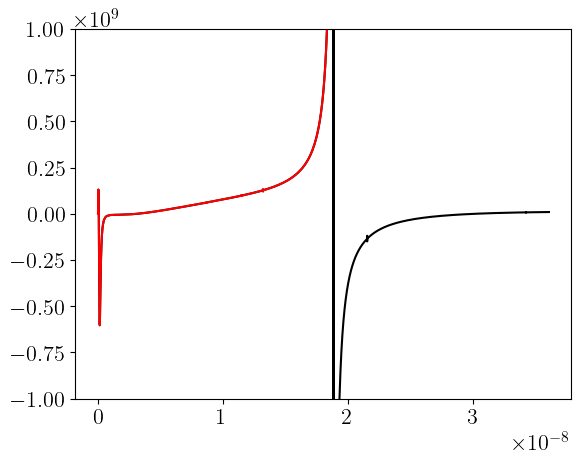

In [258]:
diff_max = 1e9
plt.plot(t, eta_t, 'k-')

plt.plot(t[:cut_ind - 10], eta_t[:cut_ind - 10], 'r')
# plt.plot(t[np.diff(eta_t, prepend=0) > diff_max], eta_t[np.diff(eta_t, prepend=0) > diff_max], 'r-')
# plt.plot(t[np.diff(eta_t, prepend=0) > diff_max], eta_t[np.diff(eta_t, prepend=0) > diff_max], 'r.')
# plt.plot(t, eta_t)
plt.ylim(-1e9, 1e9)
plt.show()

/Users/rune.hoejlund/opt/anaconda3/envs/ray-tracer/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


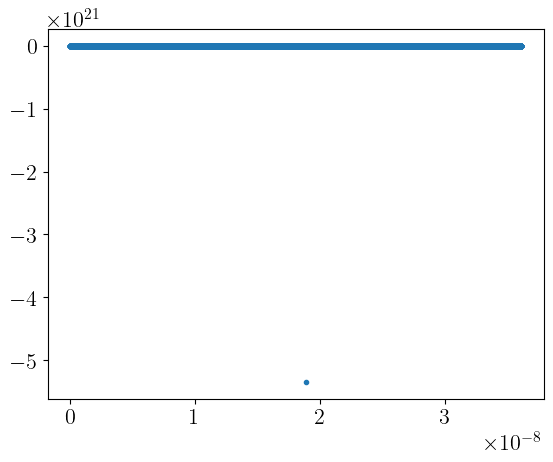

In [197]:
plt.plot(t[np.diff(eta_t, prepend=0) < 1e19], eta_t[np.diff(eta_t, prepend=0) < 1e19], '.')
plt.show()

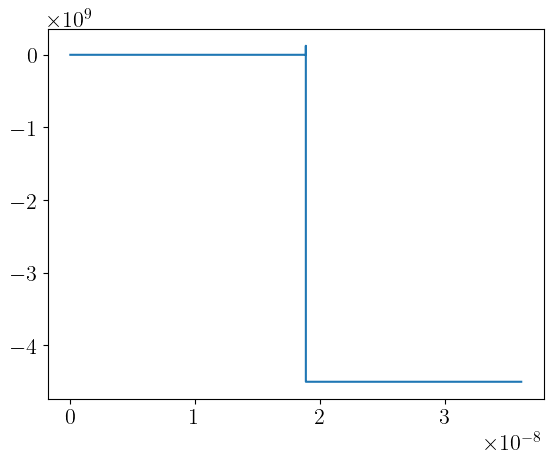

In [200]:
plt.plot(t, cumulative_trapezoid(eta_t, t, initial=0))
plt.show()

In [169]:
(np_transpose(S) @ S).shape

(40636, 2, 2)

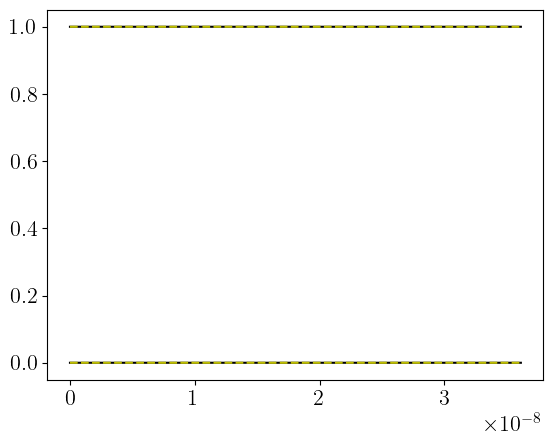

In [174]:
plt.plot(t, (np_transpose(S) @ S)[:, 0, 0], 'k-')
plt.plot(t, (np_transpose(S) @ S)[:, 0, 1], 'k-')
plt.plot(t, (np_transpose(S) @ S)[:, 1, 0], 'y--')
plt.plot(t, (np_transpose(S) @ S)[:, 1, 1], 'y--')
plt.show()

/Users/rune.hoejlund/opt/anaconda3/envs/ray-tracer/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


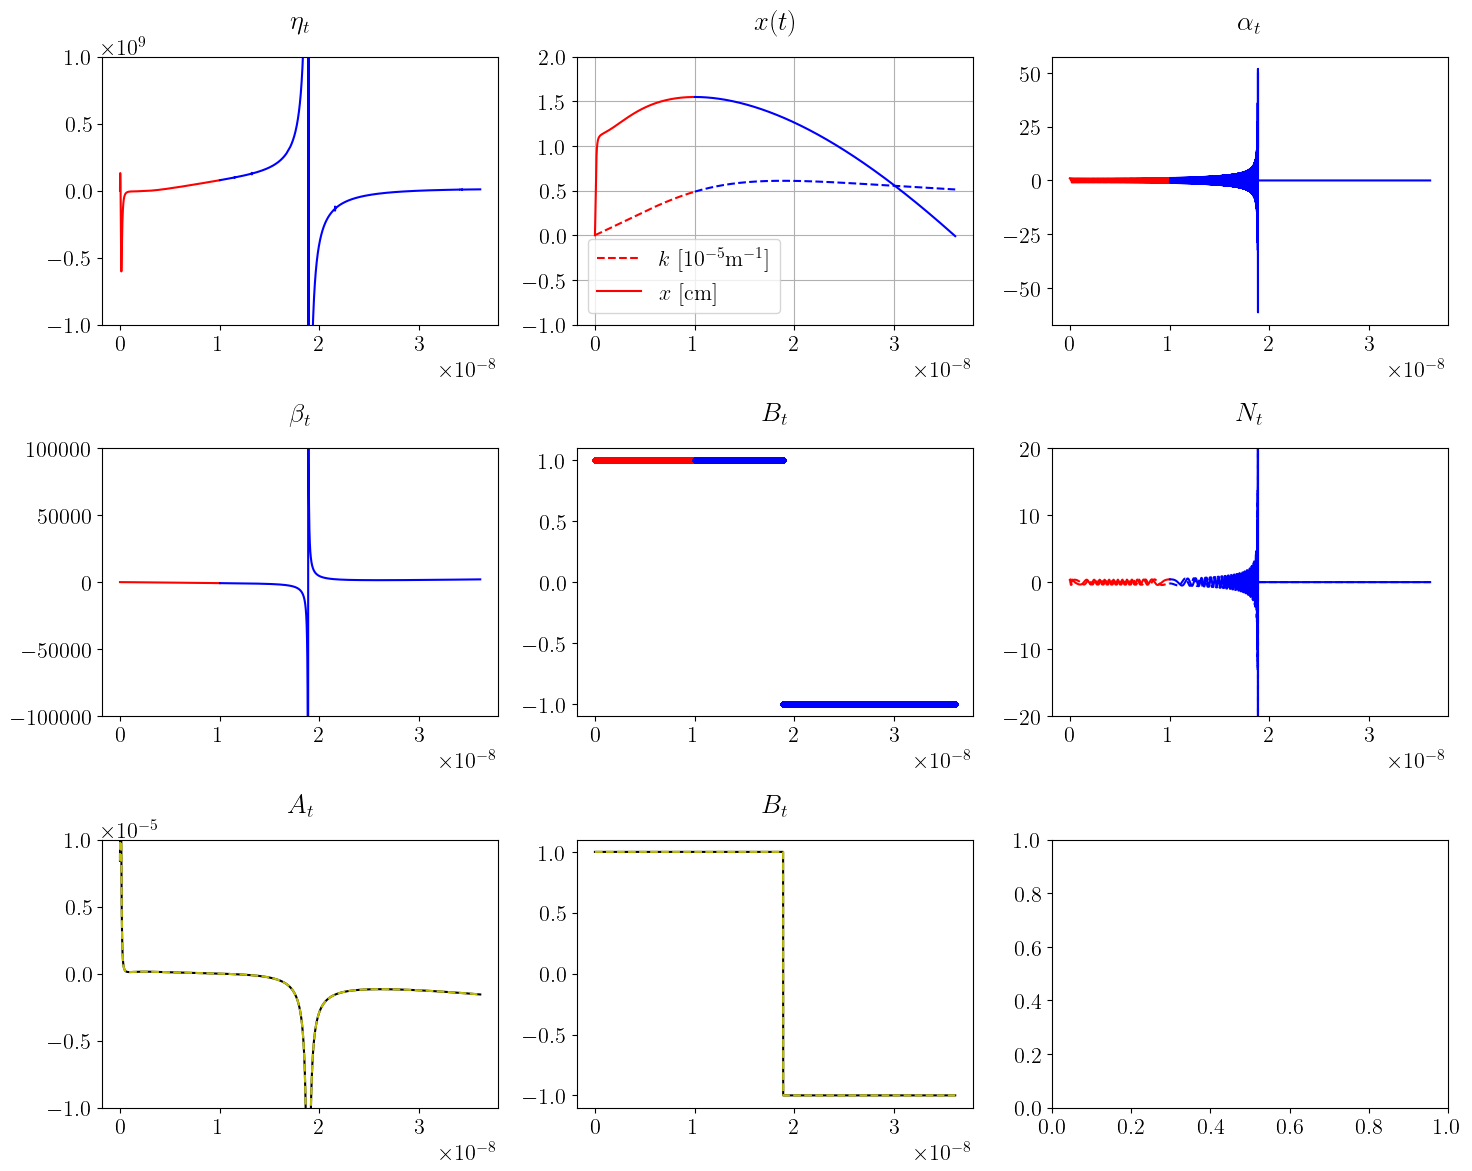

In [177]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))

ax[0, 0].set_title(r'$\eta_t$')
ax[0, 0].plot(t[branch_masks[0]], eta_t[branch_masks[0]], 'r-')
ax[0, 0].plot(t[branch_masks[1]], eta_t[branch_masks[1]], 'b-')
ax[0, 0].set_ylim(-1e9, 1e9)

ax[0, 1].set_title(r'$x(t)$')
ax[0, 1].plot(t[branch_masks[0]], ks[branch_masks[0]]*1e-5, 'r--', label=r'$k$ $[10^{-5} \mathrm{m}^{-1}]$')
ax[0, 1].plot(t[branch_masks[1]], ks[branch_masks[1]]*1e-5, 'b--')
ax[0, 1].plot(t[branch_masks[0]], xs[branch_masks[0]]*1e2, 'r-', label=r'$x$ [cm]')
ax[0, 1].plot(t[branch_masks[1]], xs[branch_masks[1]]*1e2, 'b-')
ax[0, 1].legend()
ax[0, 1].set_ylim(-1, 2)
ax[0, 1].grid()

ax[0, 2].set_title(r'$\alpha_t$')
ax[0, 2].plot(t[branch_masks[0]], alpha_t[branch_masks[0]], 'r-')
ax[0, 2].plot(t[branch_masks[1]], alpha_t[branch_masks[1]], 'b-')

ax[1, 0].set_title(r'$\beta_t$')
ax[1, 0].plot(t[branch_masks[0]], beta_t[branch_masks[0]], 'r-')
ax[1, 0].plot(t[branch_masks[1]], beta_t[branch_masks[1]], 'b-')
ax[1, 0].set_ylim(-1e5, 1e5)

ax[1, 1].set_title(r'$B_t$')
ax[1, 1].plot(t[branch_masks[0]], B_t[branch_masks[0]], 'r.')
ax[1, 1].plot(t[branch_masks[1]], B_t[branch_masks[1]], 'b.')

ax[1, 2].set_title(r'$N_t$')
ax[1, 2].plot(t[branch_masks[0]], np.real(prefact_t[branch_masks[0]]), 'r-')
ax[1, 2].plot(t[branch_masks[1]], np.real(prefact_t[branch_masks[1]]), 'b-')
ax[1, 2].plot(t[branch_masks[0]], np.imag(prefact_t[branch_masks[0]]), 'r--')
ax[1, 2].plot(t[branch_masks[1]], np.imag(prefact_t[branch_masks[1]]), 'b--')
ax[1, 2].set_ylim(-20, 20)

ax[2, 0].set_title(r'$A_t$')
ax[2, 0].plot(t, S[:, 0, 0], 'k-')
ax[2, 0].plot(t, S[:, 1, 1], 'y--')
ax[2, 0].set_ylim(-1e-5, 1e-5)

ax[2, 1].set_title(r'$B_t$')
ax[2, 1].plot(t, S[:, 0, 1], 'k-')
ax[2, 1].plot(t, -S[:, 1, 0], 'y--')

plt.tight_layout()
plt.show()

In [76]:
from scipy.interpolate import interp1d
branches = [interp1d(xs[mask], prefact_t[mask] * Upsilon[mask], bounds_error=False, fill_value='extrapolate') for mask in branch_masks[:1]]

def interp_field(x):
    return sum(f(x) for f in branches)

phi0 = 1
A0 = phi0/interp_field(5e-3)

def field(x):
    return A0 * interp_field(x)

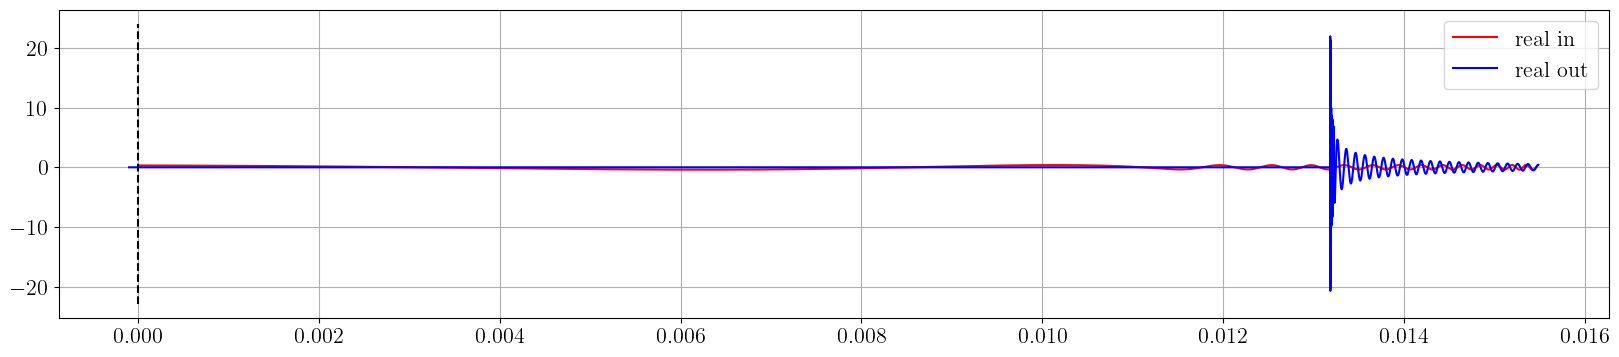

In [110]:
plt.figure(figsize=(20, 4))
xi = np.linspace(np.min(xs), np.max(xs), 200)

# plt.plot(xi, np.imag(field(xi)), '--', color='grey', label='imag sum')
plt.plot(xs[branch_masks[0]], np.real(prefact_t[branch_masks[0]]), 'r-', label='real in')
plt.plot(xs[branch_masks[1]], np.real(prefact_t[branch_masks[1]]), 'b-', label='real out')
# plt.plot(xi, np.real(field(xi)), '-', color='tab:red', label='real sum')
plt.legend()
plt.plot([x0, x0], plt.gca().get_ylim(), 'k--')
# plt.ylim(-6, 6)
plt.grid()
plt.savefig('./plots/mgo_warm_nt_' + str(nt) + '.pdf')
plt.savefig('./plots/mgo_warm_nt_' + str(nt) + '.png')
plt.show()

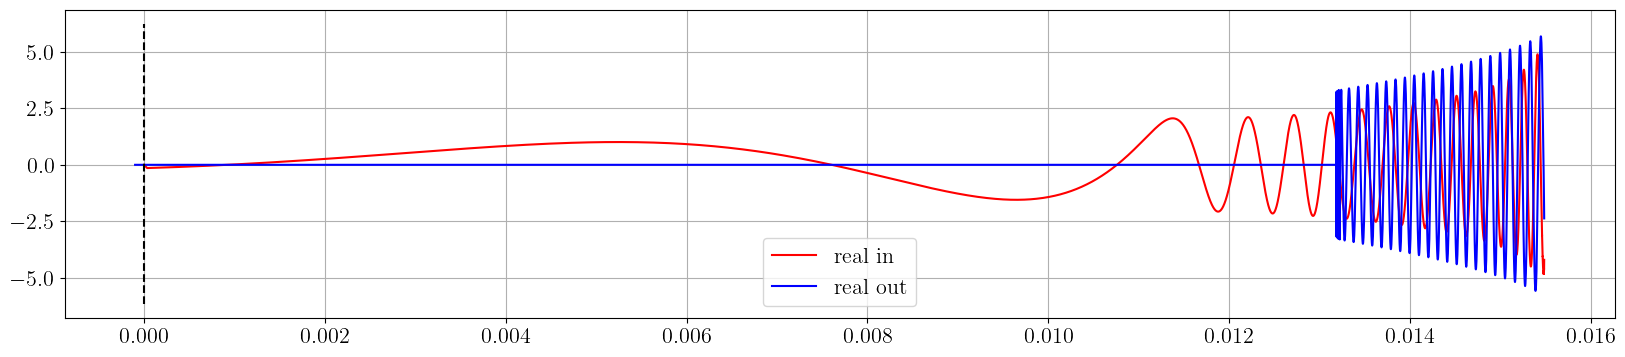

In [111]:
plt.figure(figsize=(20, 4))
xi = np.linspace(np.min(xs), np.max(xs), 200)

# plt.plot(xi, np.imag(field(xi)), '--', color='grey', label='imag sum')
plt.plot(xs[branch_masks[0]], np.real(A0*prefact_t[branch_masks[0]]*Upsilon[branch_masks[0]]), 'r-', label='real in')
plt.plot(xs[branch_masks[1]], np.real(A0*prefact_t[branch_masks[1]]*Upsilon[branch_masks[1]]), 'b-', label='real out')
# plt.plot(xi, np.real(field(xi)), '-', color='tab:red', label='real sum')
plt.legend()
plt.plot([x0, x0], plt.gca().get_ylim(), 'k--')
# plt.ylim(-6, 6)
plt.grid()
plt.savefig('./plots/mgo_warm_nt_' + str(nt) + '.pdf')
plt.savefig('./plots/mgo_warm_nt_' + str(nt) + '.png')
plt.show()

### Experiments

In [93]:
C = lambda l, sigma_p, sigma_m, s_p, s_m: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: np.exp(1j*sigma_m)/np.emath.sqrt(s_m), lambda l: np.exp(1j*sigma_p)/np.emath.sqrt(s_p)])
C_R = lambda l, sigma_p, sigma_m, s_p, s_m: np.real(C(l, sigma_p, sigma_m, s_p, s_m))
C_I = lambda l, sigma_p, sigma_m, s_p, s_m: np.imag(C(l, sigma_p, sigma_m, s_p, s_m))

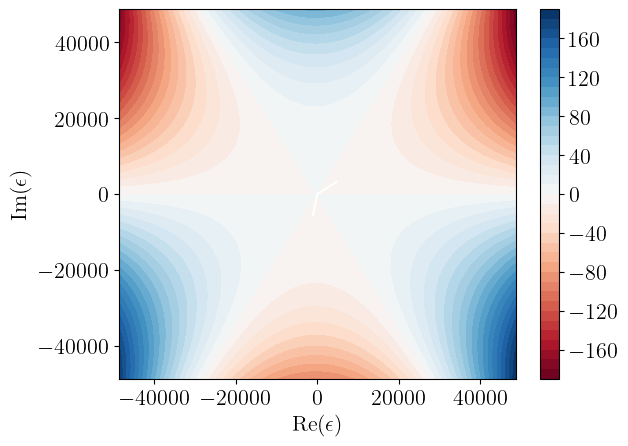

In [94]:
epsmax = np.max(np.abs(GO_t0['eps_t0']))
l_j = get_nodes_and_weights(n=10)[0].astype(np.complex_)
eps_R = np.linspace(-epsmax,epsmax, 1000)
eps_I = np.linspace(-epsmax,epsmax, 1000)
Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
Eps = Eps_R + 1j*Eps_I

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(GO_t0['f_fit'](Eps.flatten()).reshape(Eps.shape)), cmap='RdBu', levels=40)
fig.colorbar(contour_plot, ax=ax)
# ax.set_title('$t = ' + str(np.round(t0 - t[i_caust],2)) + '$')
ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

# # Plot node points along integral path
ax.plot(C_R(-l_j, sigma_p, sigma_m, s_p, s_m), C_I(-l_j, sigma_p, sigma_m, s_p, s_m), 'w')
ax.plot(C_R(l_j, sigma_p, sigma_m, s_p, s_m), C_I(l_j, sigma_p, sigma_m, s_p, s_m), 'w')
plt.savefig('./plots/mgo_warm_last_frame_nt_' + str(nt) + '.pdf')
plt.savefig('./plots/mgo_warm_last_frame_nt_' + str(nt) + '.png')
plt.show()

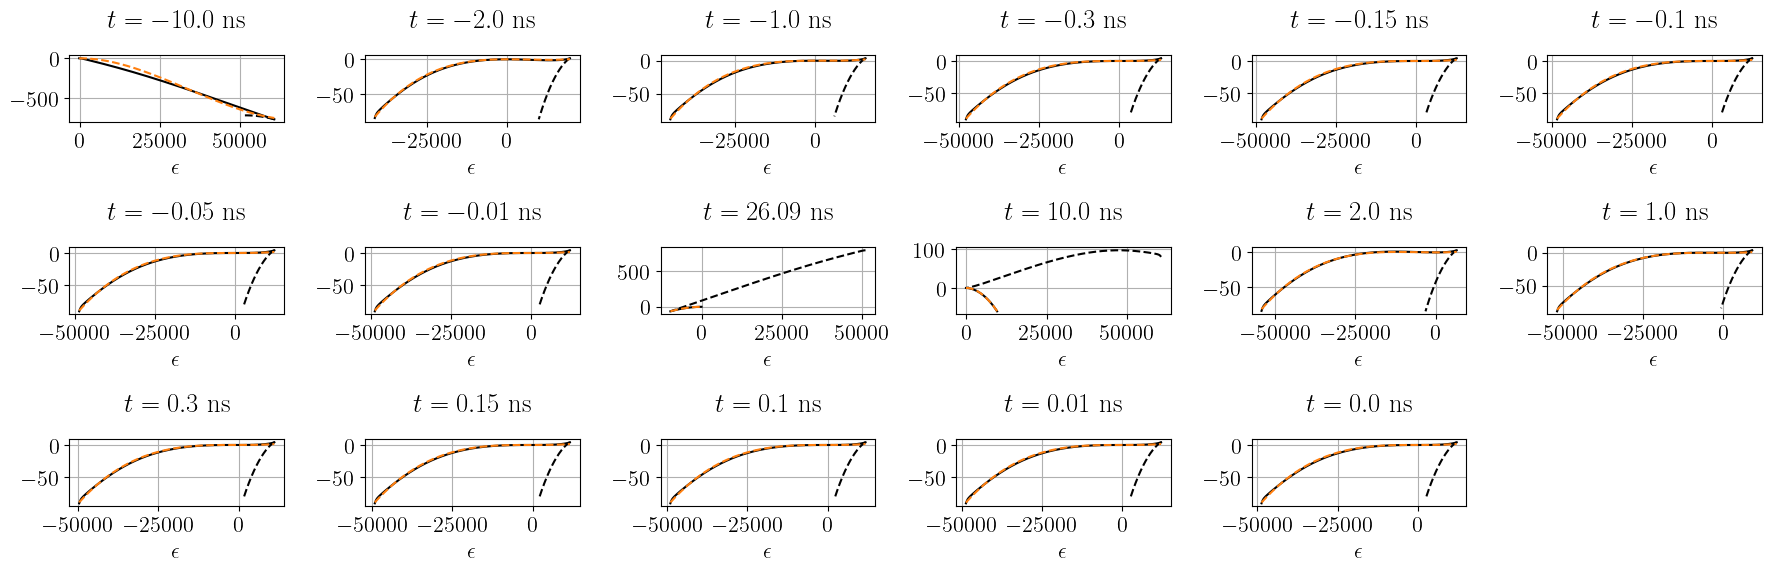

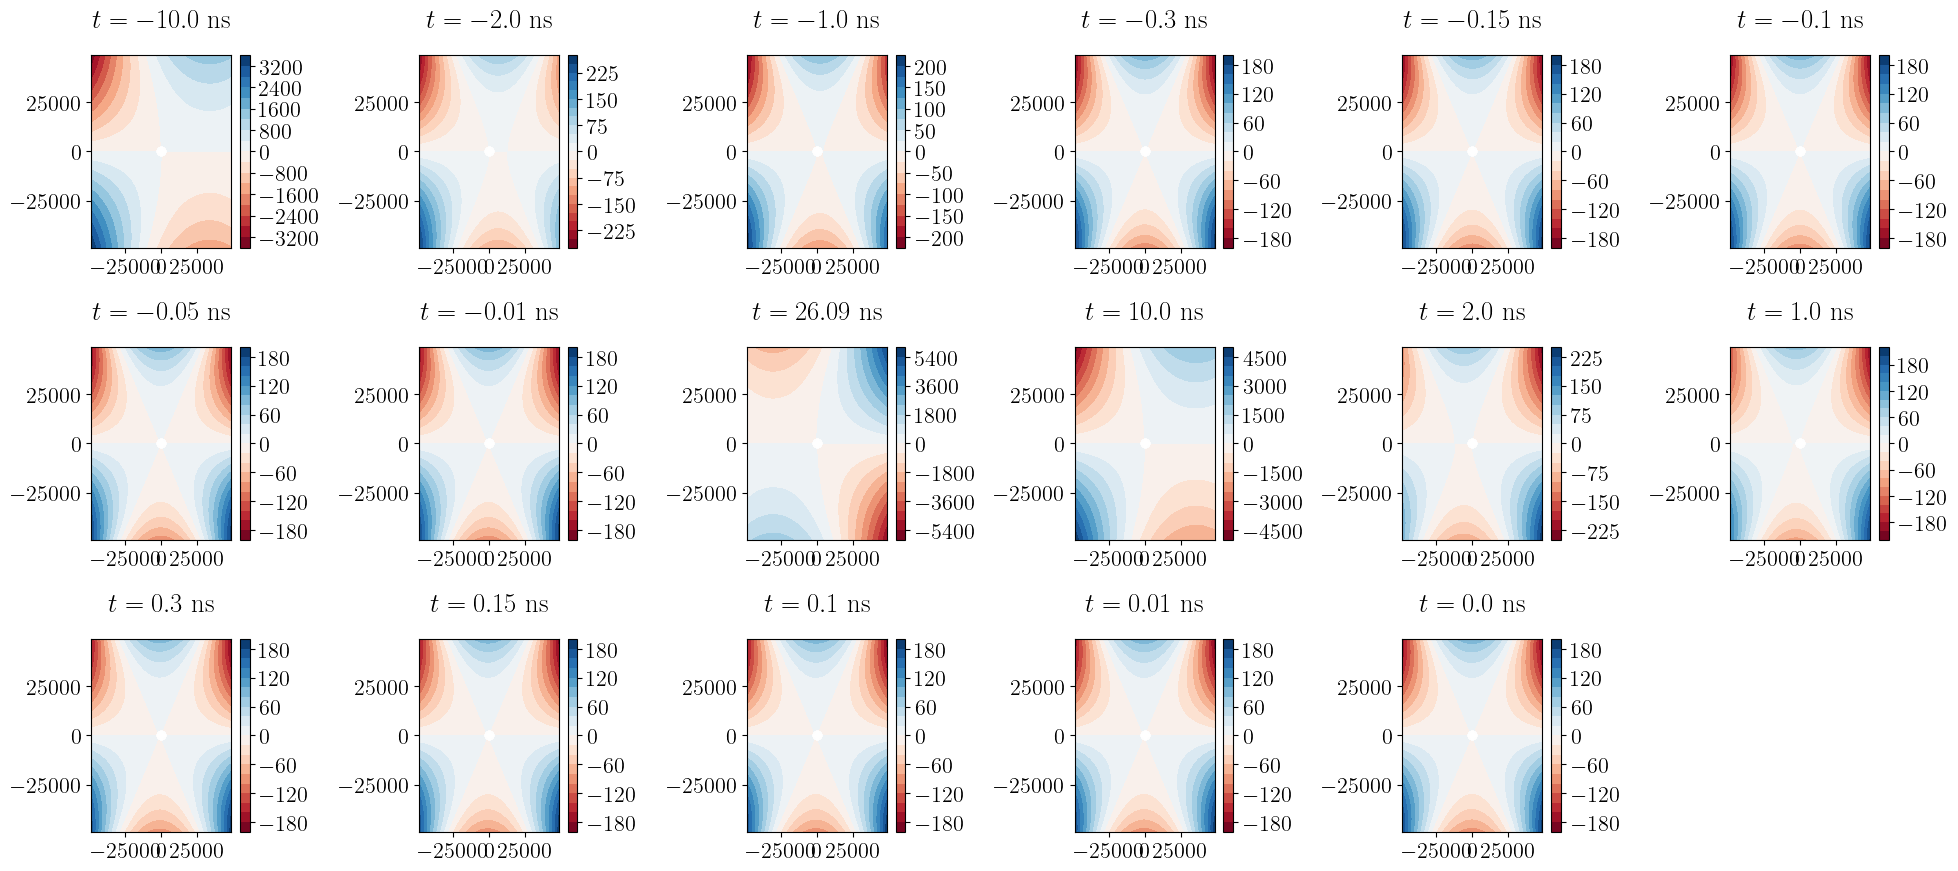

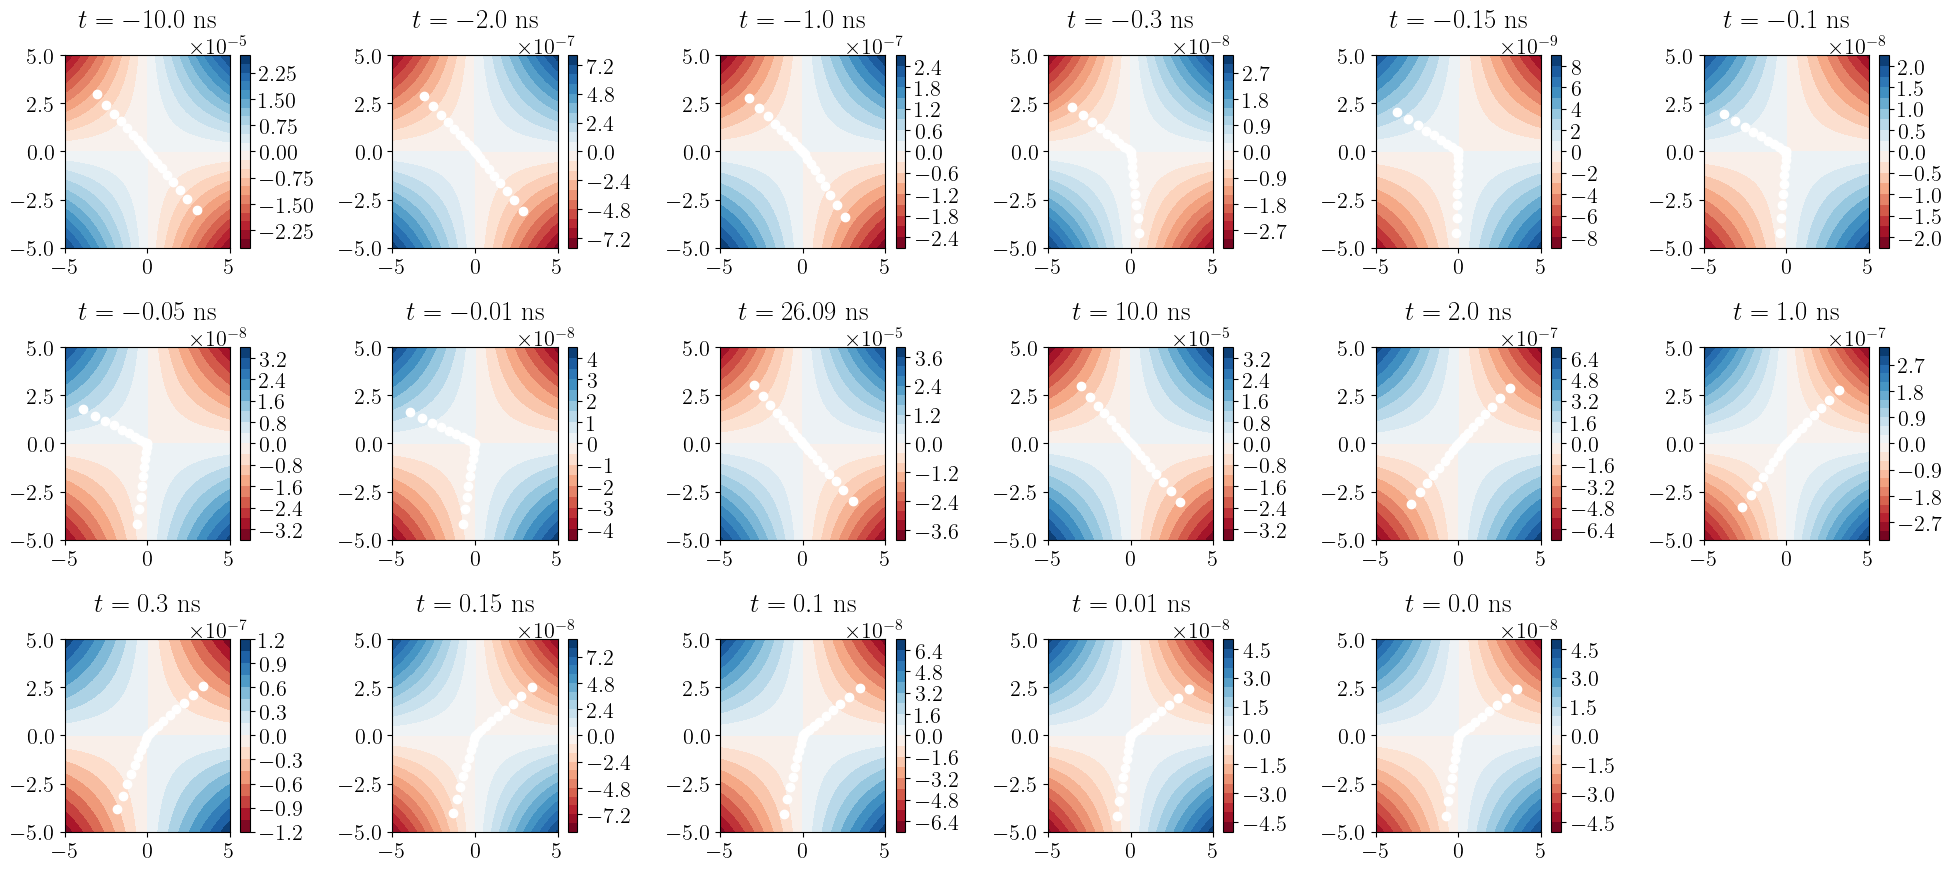

In [101]:
epsmax = np.max(np.abs(GO_t0['eps_t0']))
eps_R = np.linspace(-epsmax,epsmax, 1000)
eps_I = np.linspace(-epsmax,epsmax, 1000)
Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
Eps = Eps_R + 1j*Eps_I
l_j = get_nodes_and_weights(n=10)[0].astype(np.complex_)

ncols, nrows = 6, 3
fig = plt.figure(1, figsize=(ncols*3,nrows*2))
fig2 = plt.figure(2, figsize=(ncols*3.3,nrows*3))
fig3 = plt.figure(3, figsize=(ncols*3.3,nrows*3))

for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig.add_subplot(nrows, ncols, 1 + i)
    t0, it, mask_t0, eps_t0, f_t0, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t0', 'i', 'mask_t0', 'eps_t0', 'f_t0', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    k = ks[it]
    ax.plot(eps_t0[mask_t0], f_t0[mask_t0], 'k-')
    ax.plot(eps_t0[~mask_t0], f_t0[~mask_t0], 'k--')
    ax.plot(eps_t0[mask_t0], f_fit(eps_t0[mask_t0]), '--', color='tab:orange')
    # ax.plot(eps_rho, f_t1 - f_fit(eps_rho).squeeze(), '-', color='tab:red')
    ax.set_title('$t = ' + str(np.round((t0 - t[i_caust])*1e9,2)) + '$ ns')
    ax.set_xlabel(r'$\epsilon$')
    ax.grid()
fig.tight_layout()


for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig2.add_subplot(nrows, ncols, 1 + i)
    t0, it, mask_t0, eps_t0, f_t0, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t0', 'i', 'mask_t0', 'eps_t0', 'f_t0', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f_fit(Eps.reshape(-1, 1)).reshape(Eps.shape)), cmap='RdBu', levels=20)
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title('$t = ' + str(np.round((t0 - t[i_caust])*1e9,2)) + '$ ns')
    # ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    # ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

    # Plot node points along integral path
    ax.plot(C_R(-l_j, sigma_p, sigma_m, 1, 1), C_I(-l_j, sigma_p, sigma_m, 1, 1), 'ow')
    ax.plot(C_R(l_j, sigma_p, sigma_m, 1, 1), C_I(l_j, sigma_p, sigma_m, 1, 1), 'ow')
fig2.tight_layout()

eps_R = np.linspace(-5,5, 1000)
eps_I = np.linspace(-5,5, 1000)
Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
Eps = Eps_R + 1j*Eps_I
for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig3.add_subplot(nrows, ncols, 1 + i)
    t0, it, mask_t0, eps_t0, f_t0, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t0', 'i', 'mask_t0', 'eps_t0', 'f_t0', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f_fit(Eps.reshape(-1, 1)).reshape(Eps.shape)), cmap='RdBu', levels=20)
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title('$t = ' + str(np.round((t0 - t[i_caust])*1e9,2)) + '$ ns')
    # ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    # ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

    # Plot node points along integral path
    ax.plot(C_R(-l_j, sigma_p, sigma_m, 1, 1), C_I(-l_j, sigma_p, sigma_m, 1, 1), 'ow')
    ax.plot(C_R(l_j, sigma_p, sigma_m, 1, 1), C_I(l_j, sigma_p, sigma_m, 1, 1), 'ow')
fig3.tight_layout()
plt.show()


In [92]:
C_R(-l_j_p, sigma_p, sigma_m)

array([  42.42839451,  217.11515796,  509.51182687,  894.66852306,
       1352.13220558, 1869.37180774, 2442.34336435, 3076.67274564,
       3793.80856944, 4660.68784641])

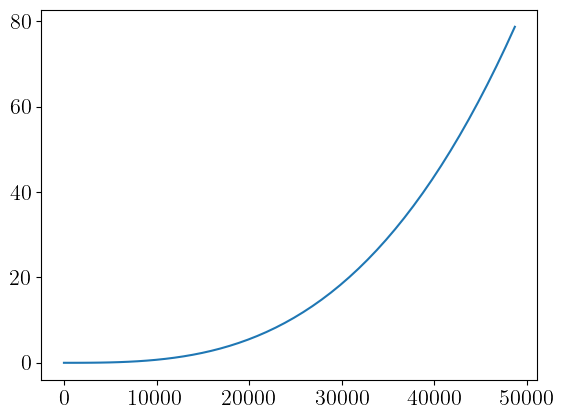

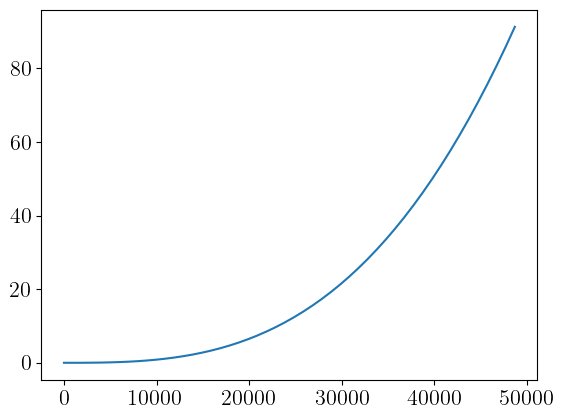

In [81]:
C_p = lambda l: np.abs(l) * np.exp(1j*sigma_p)
C_m = lambda l: np.abs(l) * np.exp(1j*sigma_m)

F_p = lambda l: np.imag(f_fit(C_p(l)))
F_m = lambda l: np.imag(f_fit(C_m(l)))

epsmax = np.max(np.abs(GO_t0['eps_t0']))
l = np.linspace(0, epsmax)
plt.plot(l, F_p(l) - F_p(0))
plt.show()
plt.plot(l, F_m(l) - F_m(0))
plt.show()

l = np.linspace(0, epsmax, dtype=np.complex_)
C = lambda l, sigma_p, sigma_m: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: np.exp(1j*sigma_m), lambda l: np.exp(1j*sigma_p)])
C_R = lambda l, sigma_p, sigma_m: np.real(C(l, sigma_p, sigma_m))
C_I = lambda l, sigma_p, sigma_m: np.imag(C(l, sigma_p, sigma_m))

In [82]:
GO_t0.keys()

dict_keys(['i', 't0', 'Xs_t0', 'Ks_t0', 'mask_t0', 'Phi_t0', 'Field_t0', 'Theta_t0', 'gamma_t0', 'f_fit', 'g_fit', 'ddf_fit', 'eps_t0', 'f_t0'])

In [83]:
from diff_func_fitters import _as_vector, _vandermonde, RationalFunction, deg_as_array, _get_degrees
from scipy import optimize

def optimize_rational_func(x, y, coef_L0, coef_M0, deg_L, deg_M):
    # If we also wish to do a non-linear optimization afterwards, this is also possible:
    L_shape = tuple(deg_L + 1)
    M_shape = tuple(deg_M + 1)

    def collect_coef(coef_L, coef_M):
        return np.concatenate([coef_L, coef_M])
    
    def unpack_coef(coef):
        coef_L = coef[:np.prod(deg_L + 1)]
        coef_M = coef[np.prod(deg_L + 1):]
        return coef_L, coef_M
    
    def model(x, *vargs):
        coef = np.concatenate([vargs])
        coef_L, coef_M = unpack_coef(coef)
        return RationalFunction(coef_L.reshape(L_shape), coef_M.reshape(M_shape))(x)

    coef = optimize.curve_fit(model, x, y, p0=collect_coef(coef_L0, coef_M0))[0]
    coef_L, coef_M = unpack_coef(coef)
    return coef_L, coef_M

def fit_rational_func(x, y, L, M, optimize=True):
    '''Returns RationalFunction fit of x, y data on the form f(x) = P_L(x)/Q_M(x)
    where P_L is a polynomial of order L and Q_M is of order M.
    
    Parameters:
    x: `np.ndarray` of shape (N, M) where N is number of datapoints, M is number of features in x.
    y: `np.ndarray` of shape (N,) where N is number of datapoints
    L: `int` or `tuple`. Nominator degrees
    M: `int` or `tuple`. Denominator degrees
        If L and M are integers, they are taken to be the highest degree
        in the nominator and denominator polynomial respectively.
        If L and M are tuples, the polynomials assume to take multidimensional inputs 
        and a monomial basis for each polynomial is generated automatically.
        The 0th order coefficient of Q_M is always taken to be 1.
    '''
    _x = _as_vector(x)
    _y = _as_vector(y)

    _deg_L = deg_as_array(L, _x.shape[-1])
    _deg_M = deg_as_array(M, _x.shape[-1])
    assert len(_deg_L) == _x.shape[-1], "length of degrees, deg_L, must match number of features in x"
    assert len(_deg_M) == _x.shape[-1], "length of degrees, deg_M, must match number of features in x"

    degrees_L = _get_degrees(_deg_L)
    degrees_M = _get_degrees(_deg_M)
    VL = _vandermonde(_x, degrees_L)
    VM = _vandermonde(_x, degrees_M)
    W = np.concatenate([VL, - _y * VM[:, 1:]], axis=1)
    coef_LM = np.linalg.lstsq(W, y, rcond=None)[0]
    coef_L = coef_LM[:np.prod(_deg_L + 1)]
    coef_M = np.concatenate([np.array([1]), coef_LM[np.prod(_deg_L + 1):]])
    
    L_shape = tuple(_deg_L + 1)
    M_shape = tuple(_deg_M + 1)

    if optimize:
        coef_L, coef_M = optimize_rational_func(x, y, coef_L, coef_M, _deg_L, _deg_M)

    return RationalFunction(coef_L.reshape(L_shape), coef_M.reshape(M_shape))

In [84]:
from diff_func_fitters import fit_polynomial

fit2 = fit_rational_func(GO_t0['eps_t0'][GO_t0['mask_t0']], GO_t0['f_t0'][GO_t0['mask_t0']], L=2, M=3)
fit3 = fit_polynomial(GO_t0['eps_t0'][GO_t0['mask_t0']], GO_t0['f_t0'][GO_t0['mask_t0']], deg=2)
print(fit2.deriv(axis=0, order=1)(0), fit3.deriv(axis=0, order=1)(0), '... should be 0')
print(fit2.deriv(axis=0, order=2)(0), fit3.deriv(axis=0, order=2)(0))

plt.plot(GO_t0['eps_t0'][GO_t0['mask_t0']], GO_t0['f_t0'][GO_t0['mask_t0']], 'k-')
plt.plot(GO_t0['eps_t0'][GO_t0['mask_t0']], GO_t0['f_fit'](GO_t0['eps_t0'][GO_t0['mask_t0']]), '--', color='tab:orange')
plt.plot(GO_t0['eps_t0'][GO_t0['mask_t0']], fit2(GO_t0['eps_t0'][GO_t0['mask_t0']]))
plt.plot(GO_t0['eps_t0'][GO_t0['mask_t0']], fit3(GO_t0['eps_t0'][GO_t0['mask_t0']]))

0.00019053303325244645 2.560361927580674e-05 ... should be 0
-1.3664251239939435e-08 -6.764544466705802e-08
